# Setup

In [68]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

from six import StringIO
import pydotplus
from ipywidgets import *
from IPython.display import display
from IPython.display import Image

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import svm, linear_model
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from xgboost import XGBClassifier

In [5]:
# Import dataframe with features
features_df = pd.read_csv('features_df.csv')

In [73]:
# Define predictor matrix
X = features_df
y = X.pop('ml')

In [74]:
# Dummify non-numeric columns
X = pd.get_dummies(X, drop_first = True)

In [75]:
# Examine feature correlations with money laundering indicator
ml_corr = abs(X.join(y).corr()[['ml']])
ml_corr.sort_values(by = 'ml', ascending = False)

,ml
ml,1.000000
kind_llp,0.743021
kind_ltd,0.731024
inactive_officers,0.709861
secrecy_officers,0.667796
active_psc,0.537770
company_officers,0.524010
active_officers,0.387897
human_officers,0.349198
kind_limited-partnership,0.130234


In [76]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [81]:
# Standardise data
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [82]:
# Check baseline
print('baseline: ', y.value_counts(normalize=True).max())

baseline:  0.5


In [83]:
# Create table for recording model scores 
model_scores = pd.DataFrame({'model':[], 'score':[]})

# Logistic regression

In [14]:
# Fit logistic regression
logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)

print('training accuracy: ', logreg.score(X_train, y_train))
print('mean cross-val score: ', cross_val_score(logreg, X_train, y_train, cv=5).mean())
print('testing accuracy: ', logreg.score(X_test, y_test))

training accuracy:  0.9501788451711803
mean cross-val score:  0.9478788383585984
testing accuracy:  0.9591419816138917


In [15]:
# Examine confusion matrix
yhat_test = logreg.predict(X_test)
conmat = np.array(confusion_matrix(y_test, yhat_test, labels=[1, 0]))
confusion = pd.DataFrame(conmat, index=['ml', 'non_ml'],
                             columns=['predicted_ml', 'predicted_non_ml'])

confusion

,predicted_ml,predicted_non_ml
ml,933,46
non_ml,34,945


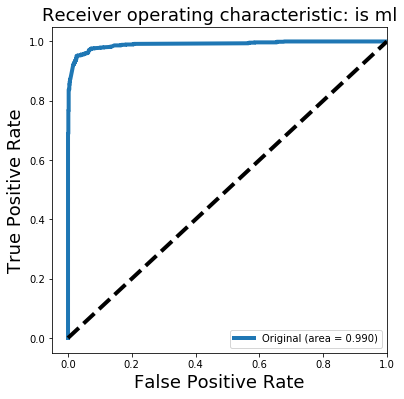

In [16]:
# Plot roc curve
yhat_test_pp = logreg.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, yhat_test_pp[:, 1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(fpr, tpr, label='Original (area = %0.3f)' % roc_auc, linewidth=4)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

ax.set_xlim([-0.05, 1.0])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=18)
ax.set_ylabel('True Positive Rate', fontsize=18)
ax.set_title('Receiver operating characteristic: is ml', fontsize=18)
ax.legend(loc="lower right")

plt.show()

In [17]:
# Tune hyperparameters with gridsearch and record best score
logreg_params = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-4, 4, 100)}

logreg_gridsearch = GridSearchCV(logreg,
                             logreg_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

# fit gridsearch on training data
logreg_gridsearch.fit(X_train, y_train);


#model_scores.loc[len(model_scores)] = ['Logistic Regression', logreg_gridsearch.best_score_]

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 239 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   41.7s finished


In [18]:
logreg_gridsearch.best_params_

{'C': 0.24770763559917114, 'penalty': 'l2', 'solver': 'liblinear'}

In [19]:
logreg_gridsearch.best_score_

0.9489013796627491

# Ridge regression

In [20]:
# Fit ridge regression
logreg_ridge = LogisticRegressionCV(Cs=100, max_iter=10000, 
                                solver='liblinear', penalty='l2', cv=5)

logreg_ridge.fit(X_train, y_train)
print('training accuracy: ', logreg_ridge.score(X_train, y_train))
print('testing accuracy: ', logreg_ridge.score(X_test, y_test))

training accuracy:  0.9497956055186509
testing accuracy:  0.9601634320735445


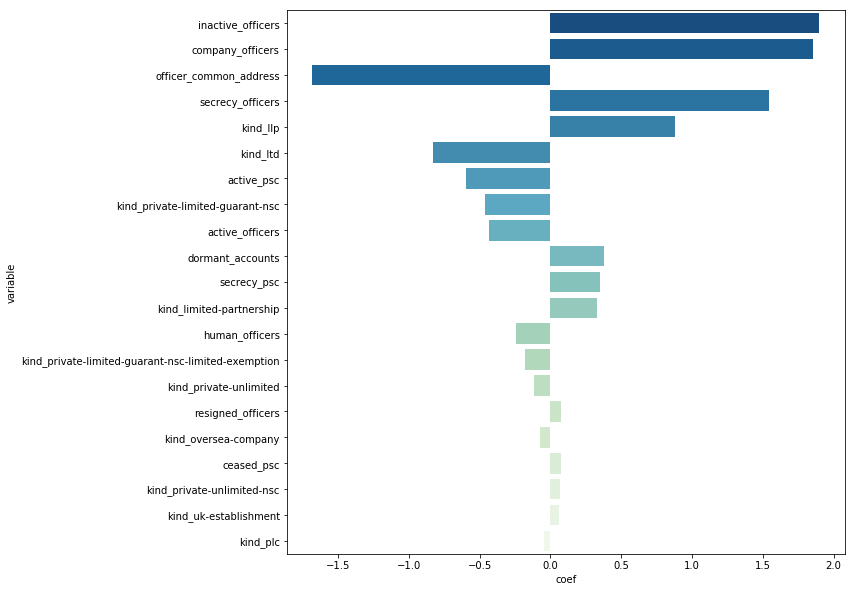

In [21]:
# Examine feature importance for ridge
coefs_vars_ridge = pd.DataFrame({
    'coef': logreg_ridge.coef_[0],
    'variable': X.columns,
    'abscoef': np.abs(logreg_ridge.coef_[0])})

coefs_vars_ridge.sort_values('abscoef', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(y=coefs_vars_ridge.variable, x=coefs_vars_ridge.coef, ax=ax,palette='GnBu_r')
plt.show()

In [22]:
# Tune hyperparameters with gridsearch and record best score
ridge_params = {'penalty': ['l2'],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'Cs': [np.logspace(-3, 0, 10)]}

ridge_gridsearch = GridSearchCV(logreg_ridge,
                             ridge_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

# fit gridsearch on training data
ridge_gridsearch.fit(X_train, y_train);


model_scores.loc[len(model_scores)] = ['Ridge Regression', ridge_gridsearch.best_score_]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  2.6min finished


# Lasso regression

In [23]:
# Fit lasso regression
logreg_lasso = LogisticRegressionCV(Cs=100, max_iter=10000, 
                                solver='liblinear', penalty='l1', cv=5)

logreg_lasso.fit(X_train, y_train)
print('training accuracy: ', logreg_lasso.score(X_train, y_train))
print('testing accuracy: ', logreg_lasso.score(X_test, y_test))

training accuracy:  0.9501788451711803
testing accuracy:  0.9606741573033708


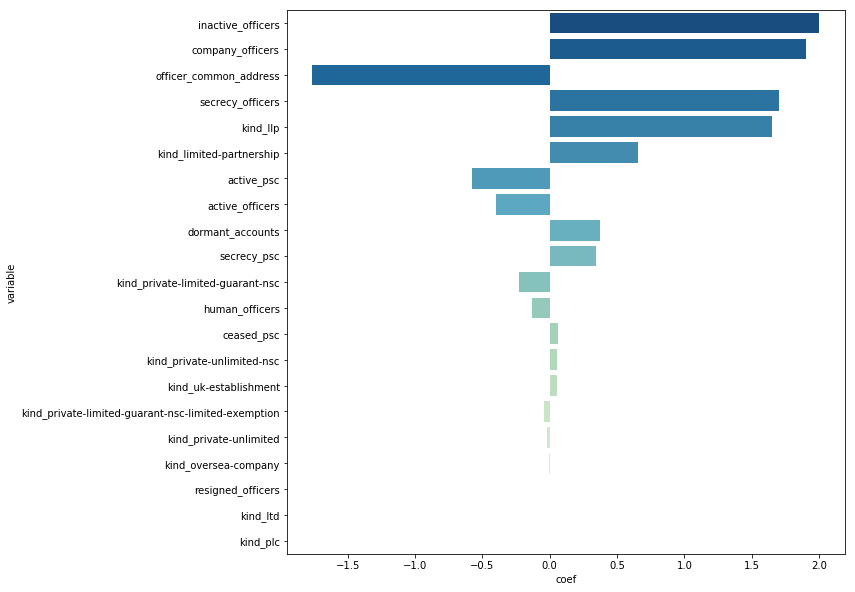

In [24]:
# Examine feature importance for lasso
coefs_vars_lasso = pd.DataFrame({
    'coef': logreg_lasso.coef_[0],
    'variable': X.columns,
    'abscoef': np.abs(logreg_lasso.coef_[0])})

coefs_vars_lasso.sort_values('abscoef', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(y=coefs_vars_lasso.variable, x=coefs_vars_lasso.coef, ax=ax, palette='GnBu_r')
plt.show()

In [28]:
# Tune hyperparameters with gridsearch and record best score
lasso_params = {'penalty': ['l1'],
                   'solver': ['liblinear'],
                   'Cs': [np.logspace(-3, 0, 10)]}

lasso_gridsearch = GridSearchCV(logreg_lasso,
                             lasso_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

# fit gridsearch on training data
lasso_gridsearch.fit(X_train, y_train);

model_scores.loc[len(model_scores)] = ['Lasso Regression', lasso_gridsearch.best_score_]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   11.7s finished


# KNN

In [30]:
# Fit knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print('training accuracy: ', knn.score(X_train, y_train))
print('mean cross-val score: ', cross_val_score(logreg, X_train, y_train, cv=5).mean())
print('testing accuracy: ', knn.score(X_test, y_test))

training accuracy:  0.9657639243740419
mean cross-val score:  0.9478788383585984
testing accuracy:  0.9611848825331971


In [31]:
# Tune hyperparameters with gridsearch and record best score

knn_params = {'n_neighbors': [5, 9, 15, 25, 40, 50, 60],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

knn_gridsearch = GridSearchCV(knn,
                             knn_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

# fit gridsearch on training data
knn_gridsearch.fit(X_train, y_train);


model_scores.loc[len(model_scores)] = ['K Nearest Neighbours', knn_gridsearch.best_score_]

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.3s
[Parallel(n_jobs=2)]: Done 140 out of 140 | elapsed:   41.5s finished


# Simple Decision Tree

In [77]:
# Fit single decision tree
dt = DecisionTreeClassifier(criterion='gini',
                                    max_depth=None, 
                                    random_state=1)
dt.fit(X_train, y_train)

print('training accuracy: ', dt.score(X_train, y_train))
print('mean cross-val accuracy: ', cross_val_score(dt, X_train, y_train, cv=5).mean())
print('testing accuracy: ', dt.score(X_test, y_test))

training accuracy:  0.9846704138988247
mean cross-val accuracy:  0.9586095840968405
testing accuracy:  0.9642492339121552


In [79]:
# Tune hyperparameters with gridsearch and record best score
dt_params = {'criterion': ['gini', 'entropy'],
             'max_depth': np.linspace(1, 15, 3),
            'max_features':range(int(3/4.*X.shape[1]), X.shape[1]+1)}

dt_gridsearch = GridSearchCV(dt,
                             dt_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

# fit gridsearch on training data
dt_gridsearch.fit(X_train, y_train);

model_scores.loc[len(model_scores)] = ['Decision Tree', dt_gridsearch.best_score_, dt_gridsearch.best_score_*100]

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 210 out of 210 | elapsed:    1.7s finished


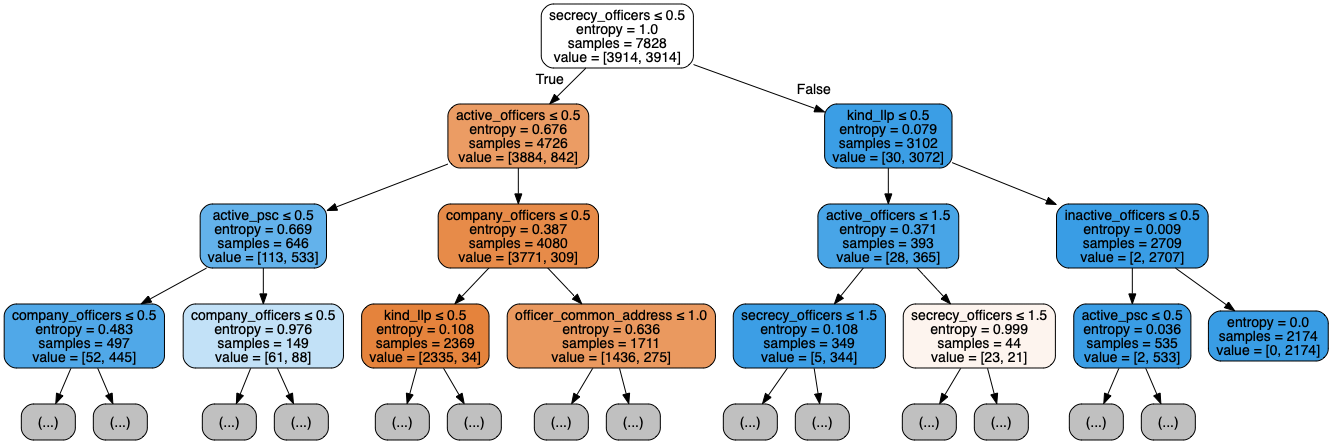

In [80]:
# Print decision tree

dot_data = StringIO()
export_graphviz(dt_gridsearch.best_estimator_,
                out_file=dot_data,
                max_depth=3,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=X.columns
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

# Random forest

In [32]:
# Fit random forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=2, random_state=99)
rf.fit(X_train, y_train)

print('training accuracy: ', rf.score(X_train, y_train))
print('mean cross-val accuracy: ', cross_val_score(rf, X_train, y_train, cv=5).mean())
print('testing accuracy: ', rf.score(X_test, y_test))

training accuracy:  0.9846704138988247
mean cross-val accuracy:  0.9666570309616433
testing accuracy:  0.9693564862104188


In [105]:
# Tune hyperparameters with gridsearch and record best score
rf_params = {'criterion': ['gini', 'entropy'],
             'max_depth': np.linspace(10,50,3),
             'n_estimators': [590,600,610]}

rf_gridsearch = GridSearchCV(rf,
                             rf_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

# fit gridsearch on training data
rf_gridsearch.fit(X_train, y_train);

model_scores.loc[len(model_scores)] = ['Random Forest', rf_gridsearch.best_score_]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:  3.1min finished


In [106]:
# Examine best parameters for best performing random forest
rf_gridsearch.best_params_

{'criterion': 'entropy', 'max_depth': 30.0, 'n_estimators': 600}

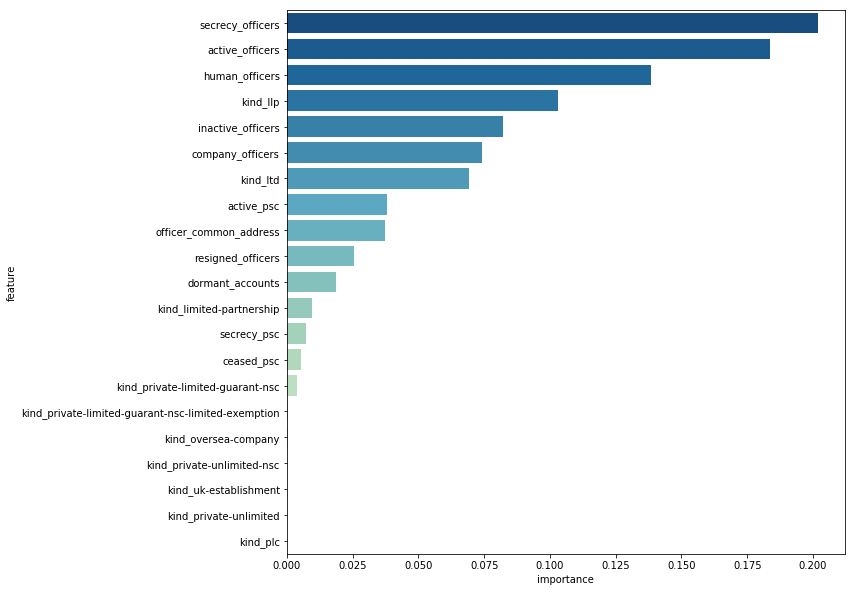

In [34]:
# Examine feature importance for random forest
coefs_vars_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_gridsearch.best_estimator_.feature_importances_})

coefs_vars_rf.sort_values('importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=coefs_vars_rf, y='feature', x='importance', ax=ax, hue="importance", dodge=False, palette='GnBu')
ax.get_legend().remove()
plt.show()

In [46]:
y_hat_train = rf_gridsearch.best_estimator_.predict(X_train)

print(classification_report(y_train, y_hat_train, digits=4))

              precision    recall  f1-score   support

           0     0.9812    0.9877    0.9845      3914
           1     0.9877    0.9811    0.9844      3914

    accuracy                         0.9844      7828
   macro avg     0.9844    0.9844    0.9844      7828
weighted avg     0.9844    0.9844    0.9844      7828



In [51]:
y_hat_test = rf_gridsearch.best_estimator_.predict(X_test)

print(classification_report(y_test, y_hat_test, digits=4))

              precision    recall  f1-score   support

           0     0.9675    0.9724    0.9699       979
           1     0.9723    0.9673    0.9698       979

    accuracy                         0.9699      1958
   macro avg     0.9699    0.9699    0.9699      1958
weighted avg     0.9699    0.9699    0.9699      1958



# Support Vector Machine

In [35]:
# Fit svm with radial basis function
svclf = svm.SVC(gamma='scale', kernel='rbf')
svclf.fit(X_train, y_train)

print('training accuracy: ', svclf.score(X_train, y_train))
print('mean cross-val accuracy: ', cross_val_score(svclf, X_train, y_train, cv=5).mean())
print('testing accuracy: ', svclf.score(X_test, y_test))

# Record best score
model_scores.loc[len(model_scores)] = ['SVM', cross_val_score(svclf, X_train, y_train, cv=5).mean()]

training accuracy:  0.9587378640776699
mean cross-val accuracy:  0.9545202888751702
testing accuracy:  0.9616956077630235


In [36]:
# Fit svm with polynomial kernel function
svclf = svm.SVC(gamma='scale', kernel='poly')
svclf.fit(X_train, y_train)

print('training accuracy: ', svclf.score(X_train, y_train))
print('mean cross-val accuracy: ', cross_val_score(svclf, X_train, y_train, cv=5).mean())
print('testing accuracy: ', svclf.score(X_test, y_test))

training accuracy:  0.9468574348492591
mean cross-val accuracy:  0.9414908558792501
testing accuracy:  0.9499489274770173


In [37]:
# Fit svm with linear kernel function
svclf = svm.SVC(gamma='scale', kernel='linear')
svclf.fit(X_train, y_train)

print('training accuracy: ', svclf.score(X_train, y_train))
print('mean cross-val accuracy: ', cross_val_score(svclf, X_train, y_train, cv=5).mean())
print('testing accuracy: ', svclf.score(X_test, y_test))

training accuracy:  0.9473684210526315
mean cross-val accuracy:  0.9474952066450435
testing accuracy:  0.9560776302349336


In [344]:
# Tune hyperparameters with gridsearch and record best score
svm_params = {'C': np.logspace(-3, 0, 10),
             'gamma': np.logspace(-5, 2, 10),
             'kernel': ['rbf', 'linear']}

svm_gridsearch = GridSearchCV(svclf,
                             svm_params,
                             n_jobs=1, 
                             cv=5, 
                             verbose=1)

# fit gridsearch on training data
svm_gridsearch.fit(X_train, y_train);

model_scores.loc[len(model_scores)] = ['SVM', svm_gridsearch.best_score_]

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 13.4min finished


In [40]:
# Try AdaBoost with decision tree
base_estimator = DecisionTreeClassifier(max_depth=3)
ab = AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=100,
                           random_state=1)
ab.fit(X_train, y_train)

print('training accuracy: ', ab.score(X_train, y_train))
print('mean cross-val score: ', cross_val_score(ab, X_train, y_train, cv=5).mean())
print('testing accuracy: ', ab.score(X_test, y_test))

model_scores.loc[len(model_scores)] = ['AdaBoost', cross_val_score(ab, X_train, y_train, cv=5).mean()]

training accuracy:  0.9836484414920798
mean cross-val score:  0.9596321120485509
testing accuracy:  0.9632277834525026


In [41]:
# Try gradient boosting  
gb = GradientBoostingClassifier(n_estimators=1000,
                                   criterion='mse',
                                   loss='exponential',
                                   max_depth=3,
                                   learning_rate=1.0,
                                   random_state=1)
gb.fit(X_train, y_train)

print('training accuracy: ', gb.score(X_train, y_train))
print('mean cross-val score: ', cross_val_score(gb, X_train, y_train, cv=5).mean())
print('testing accuracy: ', gb.score(X_test, y_test))

# Record score
model_scores.loc[len(model_scores)] = ['Gradient Boosting', cross_val_score(gb, X_train, y_train, cv=5).mean()]

training accuracy:  0.9846704138988247
mean cross-val score:  0.9625687156421788
testing accuracy:  0.9637385086823289


In [42]:
# Try xgboost
xgbclf = XGBClassifier(n_estimators=1000, learning_rate=1)
xgbclf.fit(X_train, y_train)

print('training accuracy: ', xgbclf.score(X_train, y_train))
print('mean cross-val score: ', cross_val_score(xgbclf, X_train, y_train, cv=5).mean())
print('testing accuracy: ', xgbclf.score(X_test, y_test))

# Record score
model_scores.loc[len(model_scores)] = ['XGBoost', cross_val_score(xgbclf, X_train, y_train, cv=5).mean()]

training accuracy:  0.9844149207971384
mean cross-val score:  0.9620586765440811
testing accuracy:  0.9632277834525026


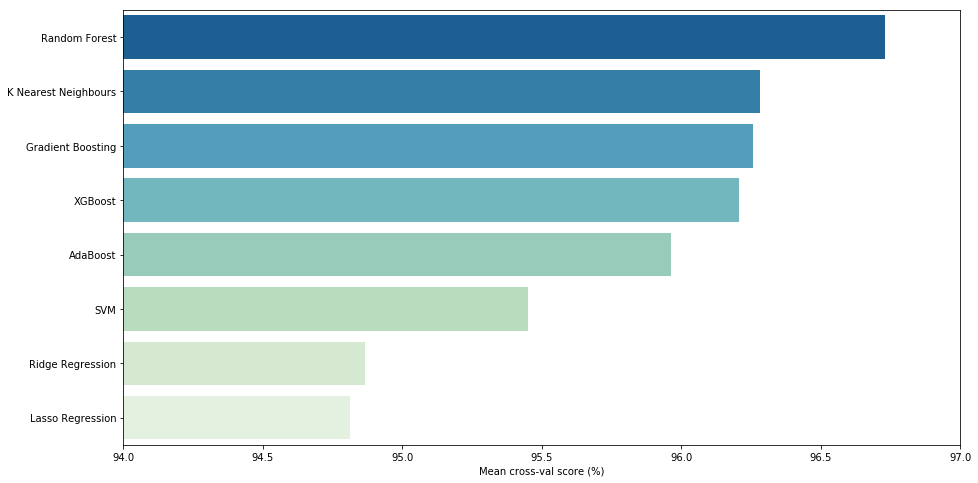

In [43]:
# Model evaluation
# Convert scores into percentage
model_scores['pct_score'] = model_scores.score*100

# plot mean cross val scores
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x="pct_score", y="model", data=model_scores.sort_values(by='score', ascending=False), hue="score", dodge=False, palette='GnBu')
ax.get_legend().remove()
ax.set(xlim=(94, 97), ylabel="", xlabel="Mean cross-val score (%)");